In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from datetime import date
import pandas as pd
import pandas_datareader.data as pdr
import yfinance as yf
yf.pdr_override()

In [3]:
def obtain_data(ticker,startdate,enddate):
   df = pdr.get_data_yahoo(ticker, start=startdate,end=enddate)
   df=df.rename({'Open':'open_price','Close':'close_price','High':'high','Low':'low','Volume':'volume'},axis='columns')
   return df

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
"""This cell defineds the plot_candles function"""

def plot_candles(pricing, title=None, volume_bars=False, color_function=None, technicals=None):
    """ Plots a candlestick chart using quantopian pricing data.
    
    Author: Daniel Treiman
    
    Args:
      pricing: A pandas dataframe with columns ['open_price', 'close_price', 'high', 'low', 'volume']
      title: An optional title for the chart
      volume_bars: If True, plots volume bars
      color_function: A function which, given a row index and price series, returns a candle color.
      technicals: A list of additional data series to add to the chart.  Must be the same length as pricing.
    """
    def default_color(index, open_price, close_price, low, high):
        return 'r' if open_price[index] > close_price[index] else 'g'
    color_function = color_function or default_color
    technicals = technicals or []
    open_price = pricing['open_price']
    close_price = pricing['close_price']
    low = pricing['low']
    high = pricing['high']
    oc_min = pd.concat([open_price, close_price], axis=1).min(axis=1)
    oc_max = pd.concat([open_price, close_price], axis=1).max(axis=1)
    
    if volume_bars:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3,1]},figsize=(7,7))
    else:
        fig, ax1 = plt.subplots(1, 1)
    if title:
        ax1.set_title(title)
    fig.tight_layout()
    x = np.arange(len(pricing))
    candle_colors = [color_function(i, open_price, close_price, low, high) for i in x]
    candles = ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, linewidth=0)
    lines = ax1.vlines(x , low, high, color=candle_colors, linewidth=1)
    ax1.xaxis.grid(True)
    ax1.yaxis.grid(True)
    ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top='off')
    ax1.set_yticklabels([])
    # Assume minute frequency if first two bars are in the same day.
    frequency = 'minute' if (pricing.index[1] - pricing.index[0]).days == 0 else 'day'
    time_format = '%d-%m-%Y'
    if frequency == 'minute':
        time_format = '%H:%M'
    # Set X axis tick labels.
    #plt.xticks(x, [date.strftime(time_format) for date in pricing.index], rotation='vertical')
    for indicator in technicals:
        ax1.plot(x, indicator)
    
    if volume_bars:
        volume = pricing['volume']
        volume_scale = None
        scaled_volume = volume
        if volume.max() > 1000000:
            volume_scale = 'M'
            scaled_volume = volume / 1000000
        elif volume.max() > 1000:
            volume_scale = 'K'
            scaled_volume = volume / 1000
        ax2.bar(x, scaled_volume, color=candle_colors)
        volume_title = 'Volume'
        if volume_scale:
            volume_title = 'Volume (%s)' % volume_scale
        #ax2.set_title(volume_title)
        ax2.xaxis.grid(True)
        ax2.set_yticklabels([])
        ax2.set_xticklabels([])
    return fig    

In [6]:
def get_ativos(file):
    file = file
    x1 = pd.read_excel(file)
    Filtro = x1['Filtro'] != 1
    x1 = x1[Filtro]
    tickers = x1.Codigo[0:90]+".SA"
    tickers = pd.DataFrame(tickers)
    tickers = tickers.reset_index()
    tickers = tickers['Codigo']
    return tickers

equities=pd.Series(get_ativos('drive/MyDrive/Data/ibovespa.xls'))

In [7]:
for equity in equities :
    df_pricing=obtain_data(equity,date(2022,1,1),date(2022,12,31))
    df=df_pricing.copy()
    df=df.reset_index(drop=True)
    n_days=5
    fraction_movement=0.10
    df['Trend']=None
    for i in range(len(df)):
        try :
            for n in range(n_days): 
                if  df.loc[i,'close_price'] - df.loc[i+n,'close_price'] >= fraction_movement*df.loc[i,'close_price']:
                    df.loc[i,'Trend'] ='Down'
                    if i >=5 :
                        fig=plot_candles(df_pricing[i-5:i],volume_bars=True)
                        fig.savefig("drive/MyDrive/Data/candlebov/Down/{0}{1}.png".format(equity,i),dpi=70)
                    print('Down',i,n)
                    break
                elif df.loc[i+n,'close_price'] - df.loc[i,'close_price'] >= fraction_movement*df.loc[i,'close_price'] :
                    df.loc[i,'Trend']='Up'
                    if i >5 :    
                        fig=plot_candles(df_pricing[i-5:i],volume_bars=True)
                        fig.savefig("drive/MyDrive/Data/candlebov/Up/{0}{1}.png".format(equity,i),dpi=70)
                    print('Up',i,n)
                    break
                else :
                    df.loc[i,'Trend']= 'No Trend'
        except :
            print(i)
            pass

Output hidden; open in https://colab.research.google.com to view.

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
!pip install "torch==1.4" "torchvision==0.5.0"
!pip install "fastai==1.0.61"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.4/753.4 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 81.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully uninstalled torch-1.13.0+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0+cu116
    Uninstalling torchvision-0.14.0+cu116:
      Successfully uninstalled torchvision-0.14.0+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.0 requires torch==1.13.0, but you have torch 1.4.0 which is incompatible.
torchaudio 0.13.0+cu116 requires torch==1.13.0, but you have torch 1.4.0 which is incompatible.
fastai 2.7.10 requi

In [10]:
from fastai.vision import *
from fastai.metrics import error_rate

In [11]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [12]:
from pathlib import Path
path=Path('drive/MyDrive/Data/candlebov')
path_save=Path('drive/MyDrive/Data/Processed')

In [13]:
path.ls()

[PosixPath('drive/MyDrive/Data/candlebov/.ipynb_checkpoints'),
 PosixPath('drive/MyDrive/Data/candlebov/Down'),
 PosixPath('drive/MyDrive/Data/candlebov/Up')]

In [14]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.,max_rotate=3), size=224, num_workers=4).normalize(imagenet_stats)

In [15]:
data.classes

['Down', 'Up']

In [16]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [17]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate,time
0,1.160321,0.847488,0.458716,01:03
1,1.181519,0.848552,0.483945,01:02
2,1.114601,0.861389,0.465596,01:02
3,1.055369,0.858371,0.440367,01:02
4,0.976056,0.805175,0.470183,01:02
5,0.908285,0.760479,0.490826,01:02
6,0.847063,0.746446,0.490826,01:03
7,0.806342,0.715442,0.472477,01:14
8,0.778153,0.710365,0.467890,01:02
9,0.758100,0.735790,0.470183,01:03


In [42]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate,time
0,0.667761,0.688169,0.433486,01:03
1,0.668307,0.692891,0.458716,01:02
2,0.667498,0.698750,0.458716,01:03
3,0.672176,0.720998,0.463303,01:02
4,0.682167,0.715569,0.442661,01:03
5,0.687468,0.738671,0.444954,01:03
6,0.702603,0.773441,0.458716,01:03
7,0.710337,0.723295,0.458716,01:03
8,0.711702,0.742093,0.470183,01:03
9,0.714045,0.696917,0.440367,01:02


In [43]:
learn.save('Fourth Model')

In [44]:
correcti=0
list_down=[]
list_up=[]
for i in range(len(data.valid_ds)):
    prediction=learn.predict(data.valid_ds[i][0])
    if str(data.valid_ds[i][1])=="Down" and bool(prediction[1]==0) :
        correcti=correcti+1
        if prediction[2][0] >= 0.75 :
            list_down=list_down + [i]
            #print(prediction)
            #print()
    if str(data.valid_ds[i][1])=="Up" and bool(prediction[1]==1) :
        correcti=correcti+1
        if prediction[2][1] >= 0.75 :
            list_up=list_up + [i]
            #print(prediction)
            #print()
        

In [20]:
len(list_down),len(list_up)

(5, 2)

In [21]:
list_down

[0, 6, 259, 403, 414]

Down


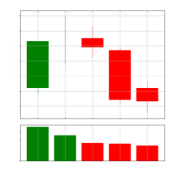

In [32]:
idx=259
x,y = data.valid_ds[idx]
x.show()
print(data.valid_ds.y[idx])

In [33]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])

In [34]:
m = learn.model.eval()

In [35]:
from fastai.callbacks.hooks import *

In [36]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [37]:
hook_a,hook_g = hooked_backward()

In [38]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 7, 7])

In [39]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [40]:
def show_heatmap(hm):
    fig,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');
    return fig

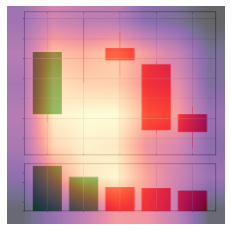

In [41]:
answer=show_heatmap(avg_acts)
answer.savefig(path/'trial.png')